**Vission Transformer (ViT)** - Replication

* The goal of Machine Learning research paper replication is to turn an ML research paper into usable code.
* Paper PDF - "https://arxiv.org/pdf/2010.11929"


# 1.Getting Setup

In [1]:
import torch
import torchvision

print(f"Torch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

Torch Version: 2.6.0+cu124
Torchvision Version: 0.21.0+cu124


In [2]:
import os
os.chdir("/content/drive/MyDrive/Data_Science/PyTorch")
os.getcwd()

'/content/drive/MyDrive/Data_Science/PyTorch'

In [3]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

[INFO] Couldn't find torchinfo... installing it.


In [4]:
# Setup device Agnostic Code.

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 2.Get Data

In [5]:
# Download pizza, steak, sushi images from GitHub
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [6]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [7]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Create dataloader

In [8]:
# Create datasets and dataloader
from going_modular.going_modular.data_setup import create_dataloaders
from torchvision import transforms

# image size
IMG_SIZE = 224 # Reference from the paper pg.no:13 - Experiment details

# Create transforms pipeline
manual_transforms = transforms.Compose([
                            transforms.Resize(size=(IMG_SIZE, IMG_SIZE)),
                            transforms.ToTensor()
                            ])
print(f"Manually created transforms:\n{manual_transforms}")

Manually created transforms:
Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [9]:
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader, test_dataloader, class_names = create_dataloaders(
                                                        train_dir = train_dir,
                                                        test_dir = test_dir,
                                                        transform = manual_transforms,
                                                        batch_size = BATCH_SIZE,
                                                        num_workers = NUM_WORKERS
                                                            )

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

## Visualize images

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

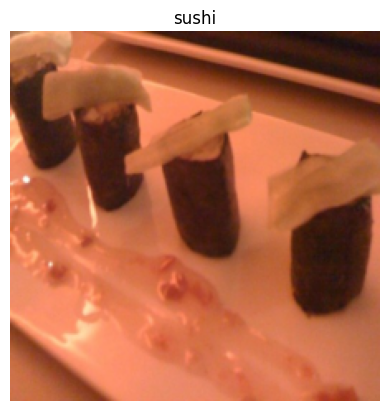

In [10]:
# get batch of images
image_batch, label_batch = next(iter(train_dataloader))

# get single image
image, label = image_batch[0], label_batch[0]

# Visualize the image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label.item()])
plt.axis("off")

# 3.Replicating ViT (Visual Transformer)
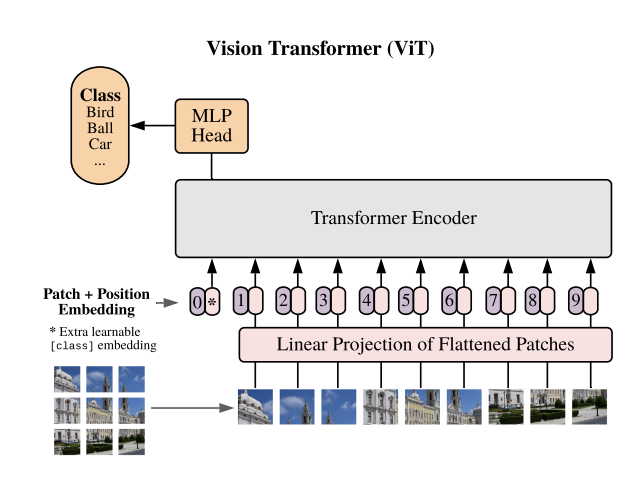

*Paper Text*
*Vision Transformer (ViT)*

An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the patch embeddings.

Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_0^0=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_L^0\right)$ serves as the image representation y (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

**Four Equations**
$$
\begin{aligned}
&\text { The MLP contains two layers with a GELU non-linearity. }\\
&\begin{aligned}
\mathbf{z}_0 & =\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_p^1 \mathbf{E} ; \mathbf{x}_p^2 \mathbf{E} ; \cdots ; \mathbf{x}_p^N \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^2 \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \\
\mathbf{z}_{\ell}^{\prime} & =\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \\
\mathbf{z}_{\ell} & =\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \\
\mathbf{y} & =\operatorname{LN}\left(\mathbf{z}_L^0\right) & &
\end{aligned}
\end{aligned}
$$


## A.Equation - 1:
Split data into patches and creating the class, position and patch embedding.

Layer = Input -> Function -> Output

* Input shape: ${H}\times{W}\times{C}$
* Output shape: $\mathbb{R}^{N \times\left(P^2 \cdot C\right)}$

where,

    H - height
    W - Weidth
    C - Color Channels
    P - Patch size
    N - No. of patches (height * width) / P^2
    D - Constant latent vector size (embedding dimension)

In [ ]:
# Creating example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate the number of patches
number_of_patches = int((height * width) / (patch_size)**2)
number_of_patches

196

In [ ]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)
print(f"Input layer shape: {embedding_layer_input_shape}")

#Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 *color_channels )
print(f"output layer shape: {embedding_layer_output_shape}")

Input layer shape: (224, 224, 3)
output layer shape: (196, 768)


### A1.Turning a single image into patches

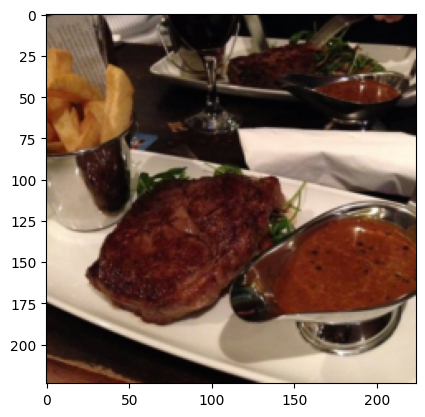

In [ ]:
plt.imshow(image.permute(1,2,0))

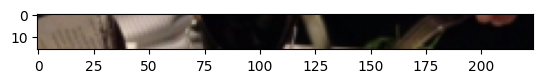

In [ ]:
# get top row of the image

image_permuted = image.permute(1,2,0)

# index to plot the top row
patch_size = 16
plt.imshow(image_permuted[:patch_size, : , :])

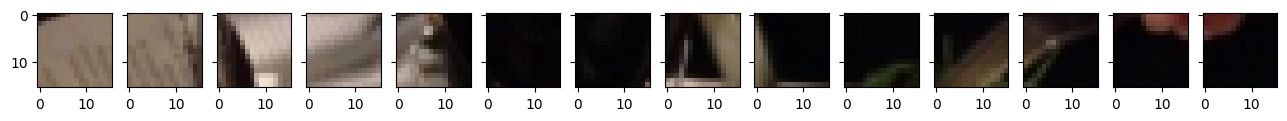

In [ ]:
# Setup code to plot top row as patches
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch_size"

# Create series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols= img_size // patch_size,
                        sharex= True, sharey=True, figsize=(patch_size,patch_size))
# Iterate on top row
for i, patch in enumerate(range(0,img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, : ])


Number of patches per row: 14.0
Number of patches per column: 14.0
Total patches: 196.0
Patch Size: (16 * 16) pixels


Text(0.5, 0.98, 'steak --> Patchified')

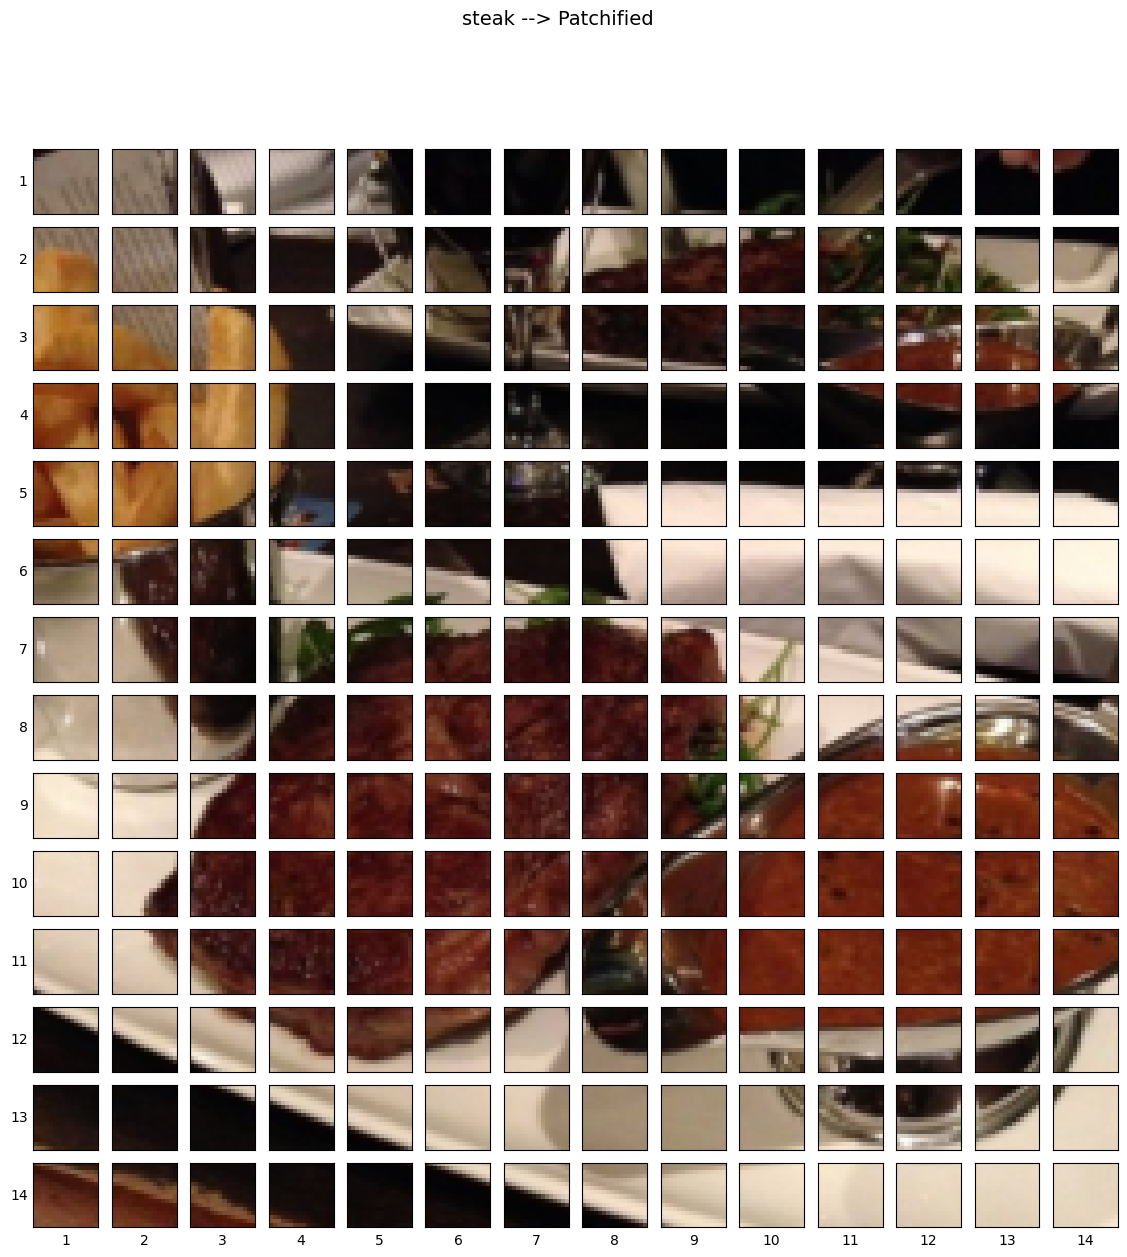

In [ ]:
# Setup for whole image
image_permuted = image.permute(1,2,0)
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch_size"
print(f"Number of patches per row: {num_patches}\
\nNumber of patches per column: {num_patches}\
\nTotal patches: {num_patches * num_patches}\
\nPatch Size: ({patch_size} * {patch_size}) pixels")

# series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size,ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True, sharey=True)

for i, patch_height in enumerate(range(0,img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                        patch_width:patch_width+patch_size, :])

        axs[i,j].set_ylabel(i+1,
                            rotation = "horizontal",
                            horizontalalignment = "right",
                            verticalalignment = "center")
        axs[i,j].set_xlabel(j+1)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].label_outer()

# Title
fig.suptitle(f"{class_names[label]} --> Patchified", fontsize=14)

### A2. Creating image patches and turning them into patch embeddings

In [ ]:
#  Using CNN architecture

from torch import nn

patch_size = 16

conv2d_layer = nn.Conv2d(in_channels=3,
                         out_channels= 768,
                         kernel_size=patch_size,
                         stride=patch_size,
                         padding = 0)

# Pass the image through conv2d layer
image_out_of_conv2d = conv2d_layer(image.unsqueeze(0)) # add batch dimension
print(f"Shape of image after conv2d layer: {image_out_of_conv2d.shape} --> (batch_size, embedding_dimension, featuremap_height, featuremap_width)")

Shape of image after conv2d layer: torch.Size([1, 768, 14, 14]) --> (batch_size, embedding_dimension, featuremap_height, featuremap_width)


In [ ]:
# Flatten layer
flatten_layer = nn.Flatten(start_dim=2, end_dim=3)
flatten_image = flatten_layer(image_out_of_conv2d)
print(f"Image size after flatten layer : {flatten_image.shape}")

Image size after flatten layer : torch.Size([1, 768, 196])


In [ ]:
# Rearange output of flatten layer --> (batch, number of patches, embedding dimensions )

flattened_image_permuted = flatten_image.permute(0,2,1).shape
flattened_image_permuted

torch.Size([1, 196, 768])

### A3. Creating patch embedding layer into Pytorch module.

In [12]:
class PatchEmbedding(nn.Module):
    # Initilize the layer
    def __init__(self, in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int = 768):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embedding_dim = embedding_dim

        # Create a layer to turn image into patches
        self.patcher = nn.Conv2d(in_channels = self.in_channels,
                                 out_channels = self.embedding_dim,
                                 kernel_size= self.patch_size,
                                 stride = self.patch_size, padding = 0)

        # Create layer to flatten the patches
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        # Create the assertion to check that input are in correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape:{image_resolution} - patch_size: {self.patch_size}"

        # perform forward pass
        x_patched = self.patcher(x)
        x_flatten = self.flatten(x_patched)

        # Make sure returned embedding dimension are in correct order: {batch_size, number_of_patches, embedding_dimension}
        return x_flatten.permute(0,2,1)

In [ ]:
set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim= 768)

# Pass single image into patch embedding
print(f"Input Image Size: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0))
print(f"Output shape of patch embedding layer: {patch_embedded_image.shape}")

Input Image Size: torch.Size([1, 3, 224, 224])
Output shape of patch embedding layer: torch.Size([1, 196, 768])


### A4. Creating class token embedding

In [ ]:
# Get batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

batch_size, embedding_dimension

(1, 768)

In [ ]:
# Create class token embedding as a learnable parameter that shares the same size as embedding dimension
class_token = nn.Parameter(torch.ones(batch_size,1, embedding_dimension ))
class_token.shape

torch.Size([1, 1, 768])

In [ ]:
# Add class token embedding to the front of the patch embedding

patch_embedded_image_with_class_token = torch.cat((class_token, patch_embedded_image),dim=1)

print(f"Patch embedded image with class token shape:\n{patch_embedded_image_with_class_token.shape} -> (batch_size, class_token + number_of_patches, embedding_dimensions)")

Patch embedded image with class token shape:
torch.Size([1, 197, 768]) -> (batch_size, class_token + number_of_patches, embedding_dimensions)


In [ ]:
patch_embedded_image_with_class_token[0]

tensor([[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
        [-0.9367,  0.2304, -0.2421,  ...,  0.6643, -0.4334,  0.3613],
        [-1.0070,  0.2692, -0.2000,  ...,  0.7158, -0.4675,  0.3300],
        ...,
        [-0.4357,  0.0886, -0.2266,  ...,  0.2279, -0.1188,  0.4053],
        [-0.2672,  0.0792, -0.1765,  ...,  0.2662, -0.0755,  0.1098],
        [-0.2222,  0.0906, -0.1315,  ...,  0.2308, -0.0616,  0.0505]],
       grad_fn=<SelectBackward0>)

### A5. Creating Positional Embedding

In [ ]:
# Calculate 'N'
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_token.shape[-1]

# Create learnable 1D positional embedding
position_embedding = nn.Parameter(torch.ones(batch_size, number_of_patches+1, embedding_dimension))

position_embedding, position_embedding.shape

In [ ]:
# Append the position embedding to patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_token + position_embedding

patch_and_position_embedding, patch_and_position_embedding.shape


### A6. Putting it all together: from image to embedding

In [13]:
set_seeds()

# 1.Set patch size
patch_size = 16

# 2.Print the shape of original image
print(f"Image Tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3.Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels = 3, patch_size = patch_size, embedding_dim = 768 )

# 5.Pass input image through Patch embedding layer
patch_embedded_image = patch_embedding_layer(x)
print(f"Output shape of patch embedded image: {patch_embedded_image.shape}")

# 6.Create class token
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension))
print(f"Class token embedding shape: {class_token.shape }")

# 7.Prepend class token with patch embedded image
patch_embedded_image_with_class_token = torch.cat((class_token, patch_embedded_image), dim=1)
print(f"Shape of patch embedden image with class token: {patch_embedded_image_with_class_token.shape}")

# 8.Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(batch_size, number_of_patches+1, embedding_dimension))
print(f"Shape of position embedding: {position_embedding.shape}")

# 9.Append position embedding to embedded imahe with class
patch_and_position_embedding = patch_embedded_image_with_class_token + position_embedding
print(f"Shape of class and position embedding: {patch_and_position_embedding.shape}")

Image Tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Output shape of patch embedded image: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Shape of patch embedden image with class token: torch.Size([1, 197, 768])
Shape of position embedding: torch.Size([1, 197, 768])
Shape of class and position embedding: torch.Size([1, 197, 768])


## B.Equation - 2:
**Multihead self Attention**

In [14]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """
    Create a multi head self attention block
    """
    def __init__(self,
                 embedding_dim:int = 768,
                 num_heads:int=12,
                 attention_dropouts:int=0):
        super().__init__()

        # Create norm layer
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create multi head self attention
        self.multiheadattention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                        num_heads=num_heads,
                                                        dropout=attention_dropouts,
                                                        batch_first=True)  #(batch, sequence, features)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, attn_weights = self.multiheadattention(query=x, key=x, value=x, need_weights = False)

        return attn_output



In [15]:
#Create instance

msa_block = MultiHeadSelfAttentionBlock()

# Pass the embedding layer to msa block
patched_embedding_through_msa_block = msa_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"output shape of MSA block: {patched_embedding_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
output shape of MSA block: torch.Size([1, 197, 768])


In [16]:
# Lets see the difference in value
patch_and_position_embedding

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.2206, 1.1472, 0.9554,  ..., 1.4347, 0.5791, 1.2003],
         [0.3186, 1.1030, 0.9485,  ..., 1.4051, 0.6176, 1.2538],
         ...,
         [0.4204, 1.0405, 0.9648,  ..., 1.2644, 0.6847, 1.2683],
         [0.4157, 1.0120, 1.0537,  ..., 1.2609, 0.6433, 1.2097],
         [0.3987, 1.0438, 0.9359,  ..., 1.3473, 0.6832, 1.2301]]],
       grad_fn=<AddBackward0>)

In [17]:
patched_embedding_through_msa_block

tensor([[[-0.2258, -0.3200,  0.0740,  ..., -0.4054,  0.9252, -0.4780],
         [-0.2239, -0.3175,  0.0768,  ..., -0.4093,  0.9325, -0.4852],
         [-0.2249, -0.3177,  0.0768,  ..., -0.4095,  0.9322, -0.4850],
         ...,
         [-0.2248, -0.3185,  0.0768,  ..., -0.4078,  0.9325, -0.4849],
         [-0.2246, -0.3193,  0.0762,  ..., -0.4092,  0.9325, -0.4849],
         [-0.2257, -0.3178,  0.0772,  ..., -0.4080,  0.9327, -0.4848]]],
       grad_fn=<TransposeBackward0>)